In [201]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [202]:
insurance_data = pd.read_csv("insurance.txt", delimiter=',')

In [203]:
del insurance_data["children"]

In [204]:
insurance_data.head()

,age,bmi,charges
0,19,27.900,16884.92400
1,18,33.770,1725.55230
2,28,33.000,4449.46200
3,33,22.705,21984.47061
4,32,28.880,3866.85520


In [205]:
def make_attrs_poly(data_df, j):
    trans = PolynomialFeatures(degree=j)
    data = data_df.to_numpy()
    X, y = data[:,:-1], data[:, -1]
    X_poly = trans.fit_transform(X)
    
    X_poly_df = pd.DataFrame(data = X_poly)
    Y_df = pd.DataFrame(data=y, columns=["charges"])
    new_data_df = pd.concat([X_poly_df, Y_df], axis=1, sort=False)
    new_data_df = (new_data_df-new_data_df.mean())/new_data_df.std()
    del new_data_df[0]
    new_data_df.insert(0, 0, 1)
    return new_data_df

In [206]:
# Splitting the dataset into training, validation and testing and adding the polynomial features in them for degrees 1..10

training_data_list = [None]*11
validation_data_list = [None]*11
testing_data_list = [None]*11

training_data_temp = insurance_data.sample(frac=0.7)
temp = insurance_data.drop(training_data_temp.index)
validation_data_temp = temp.sample(frac = 0.67)
testing_data_temp = temp.drop(validation_data_temp.index)

for j in range(1,11):
    training_data_list[j] = make_attrs_poly(training_data_temp,j)
    validation_data_list[j] = make_attrs_poly(validation_data_temp,j)
    testing_data_list[j] = make_attrs_poly(testing_data_temp,j)

In [207]:
training_data_list[1]

,0,1,2,charges
0,1,-0.666485,-0.374360,-0.725491
1,1,0.542952,0.875180,2.344075
2,1,-0.879915,0.275238,0.445539
3,1,1.254385,-0.145617,1.148534
4,1,-1.164488,-0.420760,-0.875130
...,...,...,...,...
932,1,-0.808772,-2.183955,-0.790212
933,1,-0.737628,0.785636,-0.820021
934,1,-1.520205,2.003429,-1.000630
935,1,1.112099,-0.498093,-0.231274


In [208]:
LASSO = 1
RIDGE = 2
def find_cost(theta, X, y, la, reg_type):
    theta = np.array(theta)
    if(reg_type == RIDGE):
        pred = np.matmul(X,theta)
        diff = pred-y
        cost = (np.matmul(diff.T, diff) + la*(np.matmul(theta.T, theta)))
        cost = np.array(cost)
        return np.sqrt((1/y.shape[0]) * cost[0][0])
    elif(reg_type == LASSO):
        fac = np.ones([theta.shape[0], 1],dtype=int)
        pred = np.matmul(X,theta)
        diff = pred-y
        cost = np.matmul(diff.T, diff)
        for i in range(theta.shape[0]):
            cost = cost + np.matrix(la*abs(theta[i][0]))
        
        cost = np.array(cost)
        return np.sqrt((1/y.shape[0]) *cost[0][0])
        

In [209]:
def find_grad_GD(theta, X, y, la, reg_type):
    theta = np.array(theta)
    if(reg_type == RIDGE):
        pred = np.matmul(X,theta)
        diff = pred-y
        grad = np.matmul(X.T, diff) + la*(np.matrix(theta))
        return grad
    elif(reg_type == LASSO):
        pred = np.matmul(X,theta)
        diff = pred-y
        grad = []
        X_T = X.T
        for i in range(theta.shape[0]):
            grad_w_i = np.array(np.matmul(X_T[i], diff))
            
            if(theta[i][0] > 0):
                grad_w_i = grad_w_i + la/2
            else:
                grad_w_i = grad_w_i - la/2
            
            grad.append(grad_w_i)
        grad = np.matrix(grad)
        
        return grad
            

In [210]:
def grad_desc(X, y, la, reg_type, eta, precis, epochs):
    theta = np.random.rand(X.shape[1],1)
    past_costs_train = []
    past_costs_train.append(find_cost(theta, X, y, la, reg_type))
    for i in range(epochs):
        theta = theta - eta*(1/y.shape[0])*find_grad_GD(theta, X, y, la, reg_type)
        past_costs_train.append(find_cost(theta, X,y, la, reg_type))
        if((len(past_costs_train) > 1) and abs(past_costs_train[-2]-past_costs_train[-1]) <= precis):
            break
    return theta, past_costs_train

In [211]:
def stoch_grad_desc(X, y, la, reg_type, eta, precis, epochs):
    theta = np.random.rand(X.shape[1],1)
    past_costs_train = []
    past_costs_train.append(find_cost(theta, X, y, la, reg_type))
    for i in range(epochs):
        p = np.random.permutation(len(X))
        X=X[p] 
        y=y[p]
        for j in range(x.shape[0]):
            r_x = np.array(np.matrix(X[j]))
            r_y = np.array(np.matrix(y[j]))
            theta = theta - eta*find_grad_GD(theta, r_x, r_y, la, reg_type)
        past_costs_train.append(find_cost(theta, X,y, la, reg_type))
        
        if((len(past_costs_train) > 1) and abs(past_costs_train[-2]-past_costs_train[-1]) <= precis):
            break
    
    return theta, past_costs_train

Gradient Descent without regularisation
Error values for model number 1 :-

1.355327170114902
0.9887850328310304
0.9406554866750655
0.9352074496339148
0.9345904903143868
0.9345183984589173


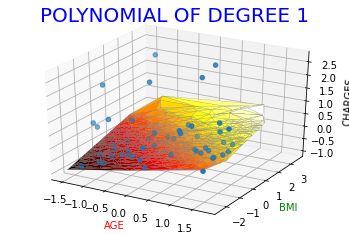

Error values for model number 2 :-

1.613766233788959
0.9475565483932873
0.9384720423773043
0.9377806638401748
0.9376253255389746
0.9375309724440701
0.9374466294655986
0.9373657531965076
0.9372874067754421
0.937211397061623
0.9371376326838288


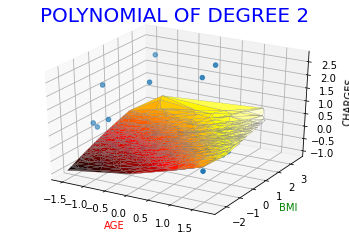

Error values for model number 3 :-

3.7225050205895815
0.941807788229429
0.9391754476109647
0.9384757276526974
0.9380629728267872
0.9377200059119948
0.9374143156517634
0.9371385329548542
0.9368890095860957
0.936662904018027
0.9364577533425079


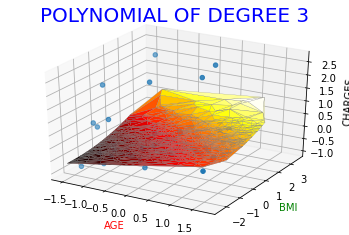

Error values for model number 4 :-

5.153210641916578
1.0215928335922786
0.9734053766203085
0.9609417308192417
0.9547011080433361
0.9502953339054218
0.9469104821694134
0.9442662993953121
0.9421924624768462
0.9405629554730208
0.9392806350655026


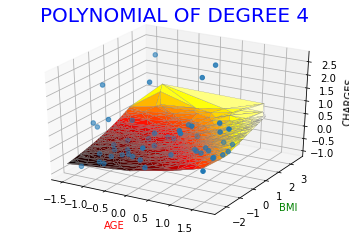

Error values for model number 5 :-

8.15880388498558
1.0120526525365645
0.9645420433075543
0.9499845217860483
0.9433307939139862
0.9396827276963725
0.9375622348534126
0.9363013075980076
0.9355395747092642
0.9350718845887406
0.9347793386535106


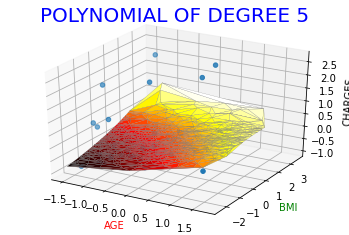

Error values for model number 6 :-

11.92993193562234
1.0188987626059711
0.9547732064431067
0.9411433143492239
0.9371947854524096
0.935703975713265
0.9350518985094877
0.9347395874906039
0.9345754230177984
0.9344779944759508
0.9344112830164035


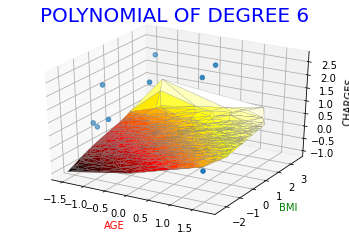

Error values for model number 7 :-

17.354135267647138
0.9833272857222187
0.9454901921471733
0.9375118453984395
0.9355595929073819
0.9349130050277871
0.9345810187216762
0.9343397568113779
0.934134513980697
0.9339503934565468
0.9337824612657806


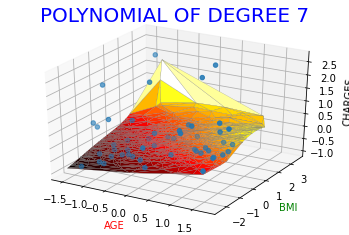

Error values for model number 8 :-

20.017960797708643
0.9671166370529856
0.9408354123970727
0.9373925185171722
0.9367998358405921
0.9365848279181695
0.9364309841607907
0.9362936996597936
0.9361653136657635
0.9360438673364958
0.9359284793428045


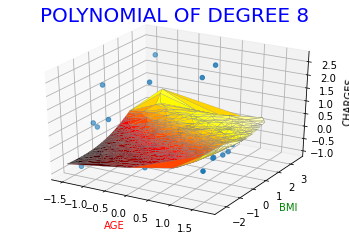

Error values for model number 9 :-

22.231302074852742
0.9587722400803915
0.9468249435390653
0.9448171124983571
0.9437768704285354
0.9429237443965053
0.9421666601493318
0.9414839767386708
0.9408639349640818
0.9402977679752982
0.9397784832720608


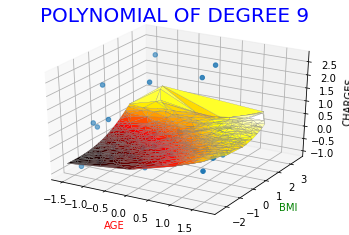

Error values for model number 10 :-

28.0043025881714
1.00267496837418
0.9499070253963602
0.942279718032115
0.9405238927828345
0.9396144861475642
0.9388833073636133
0.9382346765975451
0.9376496437961259
0.9371202047823678
0.9366404406862636


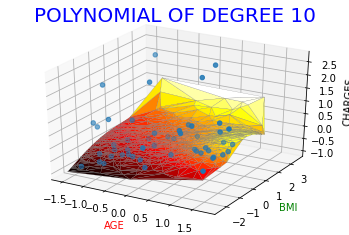

In [221]:
%matplotlib inline
test_err_gd = []
train_err_gd = []
valid_err_gd = []
print("Gradient Descent without regularisation")
for i in range(1,11):
    p = training_data_list[i].shape[1] - 1
    x = training_data_list[i][range(p)].to_numpy()
    y = training_data_list[i][['charges']].to_numpy()
    th, tr_err = grad_desc(x, y, 0, RIDGE, 0.01, 0.0000001, 1000)
    train_err_gd.append(tr_err[-1])
    
    
    print ("Error values for model number",i,":-\n")
    for j in range(len(tr_err)): 
        if j%100==0:
            
            print(tr_err[j])
    
    x_val = validation_data_list[i][range(p)].to_numpy()
    y_val = validation_data_list[i][['charges']].to_numpy()
    valid_err_gd.append(find_cost(th, x_val, y_val, 0, RIDGE))

    x_test = testing_data_list[i][range(p)].to_numpy()
    y_test = testing_data_list[i][['charges']].to_numpy()
    test_err_gd.append(find_cost(th, x_test, y_test, 0, RIDGE))

    x1 = x[:,1]
    x2 = x[:,2]
    z = np.array(np.matmul(x,th))
    fig = plt.figure()
    my_cmap = plt.get_cmap('hot') 
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i),fontsize=20, color = "Blue")
    ax.set_xlabel('AGE',color = "red")
    ax.set_ylabel('BMI',color = "green")
    ax.set_zlabel('CHARGES')
    trisurf = ax.plot_trisurf(x1.flatten(), x2.flatten(), z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    ax.scatter(x1[:50].flatten(), x2[:50].flatten(), y[:50].flatten(), zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    plt.show()


In [213]:
err_gd_df = pd.DataFrame(list(zip(train_err_gd, valid_err_gd, test_err_gd)), 
     index =['1', '2', '3', '4','5','6','7','8','9','10'], columns =[ 'GD train' , 'GD Validate', 'GD test' ])

err_gd_df

,GD train,GD Validate,GD test
1,0.934514,0.943470,0.964970
2,0.935807,0.939751,0.964985
3,0.937526,0.946072,0.951840
4,0.935616,0.941099,0.958144
5,0.933401,0.947282,0.966330
6,0.936959,0.958241,0.946152
7,0.937318,0.946645,0.975080
8,0.936120,0.946111,0.952839
9,0.932106,0.949802,0.964094
10,0.936064,0.952574,0.958093


Stochastic Gradient Descent without regularisation
Error values for model number 1 :-

1.311802500320066
0.9345241102934727
0.934543607159601


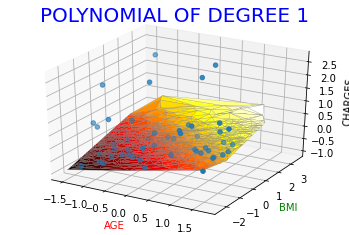

Error values for model number 2 :-

2.0609698288510137
0.935182256910496
0.9352684599860771
0.9359180232821864
0.9348613581772406
0.9350521436953867
0.9347952202654584
0.935116680802286
0.9350393989996332
0.9349031853655412
0.9347077412743707


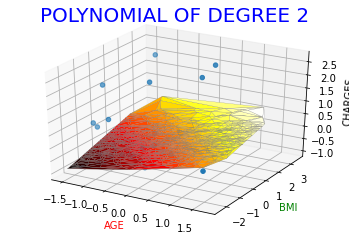

Error values for model number 3 :-

4.421054496454468
0.9414558340909871
0.9365086828002895
0.9353787338368105
0.9367883969538944
0.9348584429931969


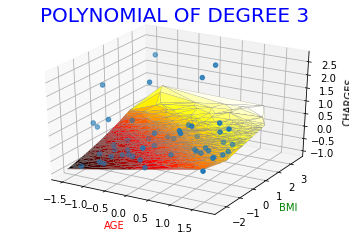

Error values for model number 4 :-

5.789198142237638
0.9382979776466384
0.9365546052611798
0.9424939843223085
0.9365276133803756
0.9360861153114948
0.9356961277128923
0.9400329203763841
0.9380544987582661
0.937696728172986
0.938826412580414


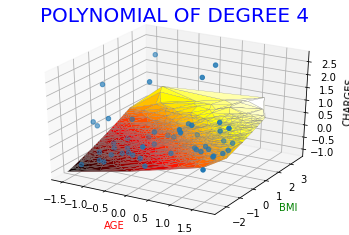

Error values for model number 5 :-

9.83728962881781
0.935701520384155
0.9384793849443079
0.9435963667559419
0.9376013679881946
0.9371350760924885
0.9391463456297967
0.9478091848747875
0.9347160060998444
0.9349743301196012
0.9547698089359921


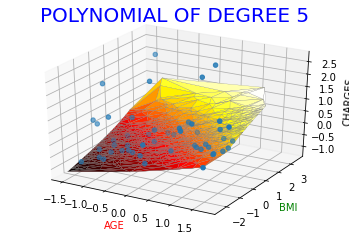

Error values for model number 6 :-

10.697546716719081
0.9447144871097962
0.9350918907337451
0.9430170902603657
0.9842720278362824
0.9385677400664665
0.935960656630957
0.9630656355834556
0.9337261868456355
0.9335552116664698
0.9559558918680336


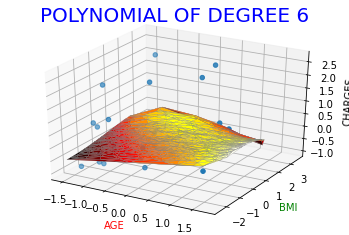

Error values for model number 7 :-

13.844373060696752
0.9373690296089676
0.9379528867000475
0.942064420814295
0.9345589195579421
0.9543559376002752
0.943434285970814
0.9355593798464555
0.9416920885702121
0.9335380001843796
0.9364337905050608


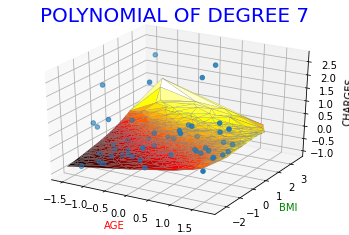

Error values for model number 8 :-

19.305419952751187
0.9366871053758349
0.9524278517378899
0.9410911182879576
0.9392105434159289
0.9341110673567723
0.9423699353173897
0.9334512263753696
0.9458036136858589
0.9327679302065187
0.9397155067639262


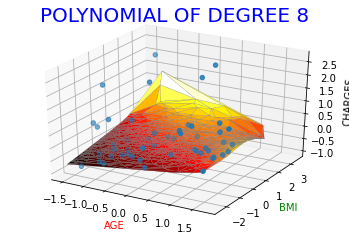

Error values for model number 9 :-

20.841019431465593
0.9388155298443527
0.9361327920542979
0.9751213072369254
0.9448600767659779
0.9607623182086528
1.0522779649114766
0.9363330112684956
0.93553805113415
0.9349955980411767
0.9346839690011686


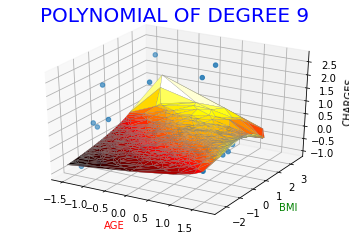

Error values for model number 10 :-

25.736409227169833
0.9611554891100119
1.0464547394742676
0.9481393285501993
0.9432454728206754
0.9322228848082731
0.9320971966168374
0.9409704023094256
0.9313096998047553
1.0085483933569521
1.0136243137757992


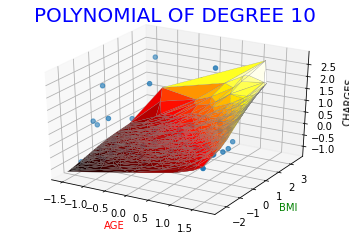

In [222]:
test_err_sgd = []
train_err_sgd = []
valid_err_sgd = []
print("Stochastic Gradient Descent without regularisation")
for i in range(1,11):
    p = training_data_list[i].shape[1] - 1
    x = training_data_list[i][range(p)].to_numpy()
    y = training_data_list[i][['charges']].to_numpy()
    th, tr_err = stoch_grad_desc(x, y, 0, RIDGE, 0.001, 0.000001, 100)
    train_err_sgd.append(tr_err[-1])
    
    print ("Error values for model number",i,":-\n")
    for j in range(len(tr_err)): 
        if j%10==0:
            print(tr_err[j])
    
    x_val = validation_data_list[i][range(p)].to_numpy()
    y_val = validation_data_list[i][['charges']].to_numpy()
    valid_err_sgd.append(find_cost(th, x_val, y_val, 0, RIDGE))

    x_test = testing_data_list[i][range(p)].to_numpy()
    y_test = testing_data_list[i][['charges']].to_numpy()
    test_err_sgd.append(find_cost(th, x_test, y_test, 0, RIDGE))
    
    
    
    x1 = x[:,1]
    x2 = x[:,2]
    z = np.array(np.matmul(x,th))
    fig = plt.figure()
    my_cmap = plt.get_cmap('hot') 
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i),fontsize=20, color = "Blue")
    ax.set_xlabel('AGE',color = "red")
    ax.set_ylabel('BMI',color = "green")
    ax.set_zlabel('CHARGES')
    trisurf = ax.plot_trisurf(x1.flatten(), x2.flatten(), z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    ax.scatter(x1[:50].flatten(), x2[:50].flatten(), y[:50].flatten(), zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    plt.show()

    

In [215]:
err_sgd_df = pd.DataFrame(list(zip(train_err_sgd, valid_err_sgd, test_err_sgd)), 
     index =['1', '2', '3', '4','5','6','7','8','9','10'], columns =[ 'SGD train' , 'SGD Validate', 'SGD test' ])

err_sgd_df

,SGD train,SGD Validate,SGD test
1,0.934590,0.942990,0.963108
2,0.934804,0.943376,0.962787
3,0.935607,0.947637,0.958156
4,0.936594,0.944156,0.961965
5,0.936071,0.946988,0.952511
6,0.933699,0.945276,0.966584
7,0.943782,0.968856,0.965655
8,0.952598,0.984690,1.019350
9,0.969643,0.995524,1.064045
10,0.950353,0.986750,0.995359


In [216]:
#LASSO REGULARISATION GRADIENT DESCENT

la_list = []

la_used_lasso = []
train_err_gd_lasso = []
valid_err_gd_lasso = []
test_err_gd_lasso = []

import random
for i in range(10):
    la_list.append(random.uniform(0, 1))

for i in range(1,11):
    train_err_gd_lasso_all = []
    valid_err_gd_lasso_all = []
    test_err_gd_lasso_all = []
    for j in range(10):
        p = training_data_list[i].shape[1] - 1
        x = training_data_list[i][range(p)].to_numpy()
        y = training_data_list[i][['charges']].to_numpy()
        th, tr_err = grad_desc(x, y, la_list[j], LASSO, 0.01, 0.000001, 1000)
        train_err_gd_lasso_all.append(tr_err[-1])
        
        x_val = validation_data_list[i][range(p)].to_numpy()
        y_val = validation_data_list[i][['charges']].to_numpy()
        valid_err_gd_lasso_all.append(find_cost(th, x_val, y_val, la_list[j], RIDGE))
        
        x_test = testing_data_list[i][range(p)].to_numpy()
        y_test = testing_data_list[i][['charges']].to_numpy()
        test_err_gd_lasso_all.append(find_cost(th, x_test, y_test, la_list[j], RIDGE))
    
    min_i = valid_err_gd_lasso_all.index(min(valid_err_gd_lasso_all))
    la_used_lasso.append(la_list[min_i])
    train_err_gd_lasso.append(train_err_gd_lasso_all[min_i])
    valid_err_gd_lasso.append(valid_err_gd_lasso_all[min_i])
    test_err_gd_lasso.append(test_err_gd_lasso_all[min_i])

err_gd_lasso_df = pd.DataFrame(list(zip(la_used_lasso, train_err_gd_lasso, valid_err_gd_lasso, test_err_gd_lasso)), 
        index =['1', '2', '3', '4','5','6','7','8','9','10'], columns =[ 'Regularisation Const', 'GD Lasso train' , 'GD Lasso Validate', 'GD Lasso test' ])
err_gd_lasso_df

,Regularisation Const,GD Lasso train,GD Lasso Validate,GD Lasso test
1,0.401931,0.934664,0.943376,0.964619
2,0.104574,0.935994,0.940796,0.964052
3,0.913454,0.941115,0.942547,0.988458
4,0.909864,0.936802,0.940594,0.960095
5,0.104574,0.936484,0.940645,0.959710
6,0.104574,0.935403,0.943238,0.958563
7,0.104574,0.935295,0.944054,0.960066
8,0.059145,0.937548,0.946267,0.958999
9,0.195602,0.939226,0.943999,0.957823
10,0.104574,0.940566,0.946539,0.953458


In [217]:
#Ridge Regularisation Gradient Descent

la_used_ridge = []
train_err_gd_ridge = []
valid_err_gd_ridge = []
test_err_gd_ridge = []
for i in range(1,11):
    train_err_gd_ridge_all = []
    valid_err_gd_ridge_all = []
    test_err_gd_ridge_all = []
    for j in range(10):
        p = training_data_list[i].shape[1] - 1
        x = training_data_list[i][range(p)].to_numpy()
        y = training_data_list[i][['charges']].to_numpy()
        th, tr_err = grad_desc(x, y, la_list[j], RIDGE, 0.01, 0.000001, 1000)
        train_err_gd_ridge_all.append(tr_err[-1])
        
        x_val = validation_data_list[i][range(p)].to_numpy()
        y_val = validation_data_list[i][['charges']].to_numpy()
        valid_err_gd_ridge_all.append(find_cost(th, x_val, y_val, la_list[j], RIDGE))
        
        x_test = testing_data_list[i][range(p)].to_numpy()
        y_test = testing_data_list[i][['charges']].to_numpy()
        test_err_gd_ridge_all.append(find_cost(th, x_test, y_test, la_list[j], RIDGE))
    
    min_i = valid_err_gd_ridge_all.index(min(valid_err_gd_ridge_all))
    la_used_ridge.append(la_list[min_i])
    train_err_gd_ridge.append(train_err_gd_ridge_all[min_i])
    valid_err_gd_ridge.append(valid_err_gd_ridge_all[min_i])
    test_err_gd_ridge.append(test_err_gd_ridge_all[min_i])

err_gd_ridge_df = pd.DataFrame(list(zip(la_used_ridge, train_err_gd_ridge, valid_err_gd_ridge, test_err_gd_ridge)), 
        index =['1', '2', '3', '4','5','6','7','8','9','10'], columns =[ 'Regularisation Const', 'GD ridge train' , 'GD ridge Validate', 'GD ridge test' ])
err_gd_ridge_df

,Regularisation Const,GD ridge train,GD ridge Validate,GD ridge test
1,0.104574,0.934568,0.943181,0.964160
2,0.195602,0.938309,0.938806,0.973331
3,0.804176,0.935820,0.941674,0.959447
4,0.804176,0.937050,0.939842,0.972968
5,0.794607,0.936157,0.941931,0.960472
6,0.086660,0.934582,0.940200,0.958859
7,0.059145,0.933885,0.945245,0.964455
8,0.059145,0.933478,0.944853,0.954206
9,0.804176,0.941646,0.945337,0.960152
10,0.909864,0.940834,0.945109,0.969178


In [218]:
#LASSO REGULARISATION STOCHASTIC GRADIENT DESCENT

la_used_sgd_lasso = []
train_err_sgd_lasso = []
valid_err_sgd_lasso = []
test_err_sgd_lasso = []
for i in range(1,11):
    train_err_sgd_lasso_all = []
    valid_err_sgd_lasso_all = []
    test_err_sgd_lasso_all = []
    for j in range(10):
        p = training_data_list[i].shape[1] - 1
        x = training_data_list[i][range(p)].to_numpy()
        y = training_data_list[i][['charges']].to_numpy()
        th, tr_err = stoch_grad_desc(x, y, la_list[j], LASSO, 0.001, 0.000001, 5)
        train_err_sgd_lasso_all.append(tr_err[-1])
        
        x_val = validation_data_list[i][range(p)].to_numpy()
        y_val = validation_data_list[i][['charges']].to_numpy()
        valid_err_sgd_lasso_all.append(find_cost(th, x_val, y_val, la_list[j], RIDGE))
        
        x_test = testing_data_list[i][range(p)].to_numpy()
        y_test = testing_data_list[i][['charges']].to_numpy()
        test_err_sgd_lasso_all.append(find_cost(th, x_test, y_test, la_list[j], RIDGE))
    
    min_i = valid_err_sgd_lasso_all.index(min(valid_err_sgd_lasso_all))
    la_used_lasso.append(la_list[min_i])
    train_err_sgd_lasso.append(train_err_sgd_lasso_all[min_i])
    valid_err_sgd_lasso.append(valid_err_sgd_lasso_all[min_i])
    test_err_sgd_lasso.append(test_err_sgd_lasso_all[min_i])

err_sgd_lasso_df = pd.DataFrame(list(zip(la_used_lasso, train_err_sgd_lasso, valid_err_sgd_lasso, test_err_sgd_lasso)), 
        index =['1', '2', '3', '4','5','6','7','8','9','10'], columns =[ 'Regularisation Const', 'SGD lasso train' , 'SGD lasso Validate', 'SGD lasso test' ])
err_sgd_lasso_df

,Regularisation Const,SGD lasso train,SGD lasso Validate,SGD lasso test
1,0.401931,0.935380,0.943470,0.961147
2,0.104574,0.938756,0.941966,0.960592
3,0.913454,0.940279,0.942716,0.965375
4,0.909864,0.943327,0.943371,0.974531
5,0.104574,0.941560,0.941410,0.965439
6,0.104574,0.941652,0.947539,0.969574
7,0.104574,0.937079,0.944026,0.954584
8,0.059145,0.940352,0.942426,0.968483
9,0.195602,0.937526,0.946635,0.971706
10,0.104574,0.952089,0.939887,0.970029


In [219]:
#RIDGE REGULARISATION STOCHASTIC GRADIENT DESCENT

la_used_sgd_ridge = []
train_err_sgd_ridge = []
valid_err_sgd_ridge = []
test_err_sgd_ridge = []
for i in range(1,11):
    train_err_sgd_ridge_all = []
    valid_err_sgd_ridge_all = []
    test_err_sgd_ridge_all = []
    for j in range(10):
        p = training_data_list[i].shape[1] - 1
        x = training_data_list[i][range(p)].to_numpy()
        y = training_data_list[i][['charges']].to_numpy()
        th, tr_err = stoch_grad_desc(x, y, la_list[j], RIDGE, 0.001, 0.000001, 5)
        train_err_sgd_ridge_all.append(tr_err[-1])
        
        x_val = validation_data_list[i][range(p)].to_numpy()
        y_val = validation_data_list[i][['charges']].to_numpy()
        valid_err_sgd_ridge_all.append(find_cost(th, x_val, y_val, la_list[j], RIDGE))
        
        x_test = testing_data_list[i][range(p)].to_numpy()
        y_test = testing_data_list[i][['charges']].to_numpy()
        test_err_sgd_ridge_all.append(find_cost(th, x_test, y_test, la_list[j], RIDGE))
    
    min_i = valid_err_sgd_ridge_all.index(min(valid_err_sgd_ridge_all))
    la_used_ridge.append(la_list[min_i])
    train_err_sgd_ridge.append(train_err_sgd_ridge_all[min_i])
    valid_err_sgd_ridge.append(valid_err_sgd_ridge_all[min_i])
    test_err_sgd_ridge.append(test_err_sgd_ridge_all[min_i])
    
err_sgd_ridge_df = pd.DataFrame(list(zip(la_used_ridge, train_err_sgd_ridge, valid_err_sgd_ridge, test_err_sgd_ridge)), 
        index =['1', '2', '3', '4','5','6','7','8','9','10'], columns =[ 'Regularisation Const', 'SGD ridge train' , 'SGD ridge Validate', 'SGD ridge test' ])
err_sgd_ridge_df

,Regularisation Const,SGD ridge train,SGD ridge Validate,SGD ridge test
1,0.104574,0.934710,0.943344,0.963152
2,0.195602,0.937214,0.941075,0.960701
3,0.804176,0.937125,0.938890,0.958693
4,0.804176,0.938124,0.938849,0.962865
5,0.794607,0.937124,0.942112,0.946844
6,0.086660,0.938648,0.938343,0.949705
7,0.059145,0.938364,0.941528,0.973097
8,0.059145,0.938778,0.939991,0.949875
9,0.804176,0.945099,0.938772,0.966930
10,0.909864,0.938898,0.937783,0.966886
